## Notebook 2: Yelp and Foursquare Data Analysis (EDA)

### Section 1: Importing Libraries

In [19]:
# Importing necessary libraries for API requests, data handling, and visualization
import os
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

### Section 2: Defining Classes

In [7]:
# Define a POI (Point of Interest) class to represent each POI
class POI:
    def __init__(self, name, latitude, longitude, rating=None, price=None, category=None, tel=None, address=None, distance=None):
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.rating = rating
        self.price = price
        self.category = category
        self.tel = tel
        self.address = address
        self.distance = distance

    def to_dict(self):
        return {
            "restaurant_name": self.name,
            "restaurant_latitude": self.latitude,
            "restaurant_longitude": self.longitude,
            "rating": self.rating,
            "price": self.price,
            "category": self.category,
            "tel": self.tel,
            "address": self.address,
            "distance": self.distance
        }

    def __repr__(self):
        return f"POI({self.name}, {self.latitude}, {self.longitude}, {self.rating}, {self.price}, {self.category})"

# Define a POINetwork class to handle multiple POIs
class POINetwork:
    def __init__(self):
        self.pois = []

    def add_poi(self, poi):
        if isinstance(poi, POI):
            self.pois.append(poi)

    def to_dataframe(self):
        return pd.DataFrame([poi.to_dict() for poi in self.pois])

    def save_to_csv(self, filename):
        df = self.to_dataframe()
        df.to_csv(filename, index=False)

    def load_from_csv(self, filename):
        df = pd.read_csv(filename)
        for _, row in df.iterrows():
            self.add_poi(POI(**row.to_dict()))

    def __repr__(self):
        return f"POINetwork({len(self.pois)} POIs)"

### Section 3: Fetching Data from APIs

#### Foursquare API

In [8]:
# Utility function to fetch data from Foursquare
def fetch_foursquare_data(lat, lon, radius=1000, query='restaurant'):
    """Fetch data from Foursquare API."""
    foursquare_api_key = os.getenv('foursquare_api_key')
    headers = {
        "accept": "application/json",
        "Authorization": foursquare_api_key
    }
    params = {
        "ll": f"{lat},{lon}",
        "radius": radius,
        "query": query,
        "fields": "fsq_id,name,geocodes,location,categories,distance,rating,price,tel"
    }

    response = requests.get("https://api.foursquare.com/v3/places/search", headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} | {response.text}")
        return {}

# Parse Foursquare response into POIs
def parse_foursquare_pois(response):
    pois = POINetwork()
    for poi in response.get('results', []):
        category = poi.get('categories', [{}])[0].get('short_name', None)
        pois.add_poi(POI(
            name=poi.get('name'),
            latitude=poi.get('geocodes', {}).get('main', {}).get('latitude'),
            longitude=poi.get('geocodes', {}).get('main', {}).get('longitude'),
            rating=poi.get('rating'),
            price=poi.get('price'),
            category=category,
            tel=poi.get('tel'),
            address=poi.get('location', {}).get('formatted_address', None),
            distance=poi.get('distance')
        ))
    return pois

#### Yelp API

In [9]:
# Utility function to fetch data from Yelp
def fetch_yelp_data(lat, lon, radius=1000, term='restaurant'):
    """Fetch data from Yelp API."""
    yelp_api_key = os.getenv("yelp_api_key")
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {yelp_api_key}"
    }
    params = {
        "latitude": lat,
        "longitude": lon,
        "radius": radius,
        "term": term
    }

    response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} | {response.text}")
        return {}

# Parse Yelp response into POIs
def parse_yelp_pois(response):
    pois = POINetwork()
    for business in response.get('businesses', []):
        category = [cat.get('title') for cat in business.get('categories', [{}])]
        pois.add_poi(POI(
            name=business.get('name'),
            latitude=business.get('coordinates', {}).get('latitude'),
            longitude=business.get('coordinates', {}).get('longitude'),
            rating=business.get('rating'),
            price=business.get('price'),
            category=category,
            tel=business.get('phone'),
            address=', '.join(business.get('location', {}).get('display_address', [])),
            distance=business.get('distance')
        ))
    return pois

### Section 4: Data Integration and Saving

In [ ]:
# Main function to fetch POIs for all bike stations
def fetch_pois_for_bike_stations(filename):
    """Fetch POIs from Foursquare and Yelp for all bike stations in the given file."""
    bike_stations = pd.read_csv(filename)

    foursquare_network = POINetwork()
    #yelp_network = POINetwork()

    for _, row in bike_stations.iterrows():
        lat, lon = row["bike_station_latitude"], row["bike_station_longitude"]

        # Fetch and parse Foursquare data
        foursquare_response = fetch_foursquare_data(lat, lon)
        foursquare_network.pois.extend(parse_foursquare_pois(foursquare_response).pois)

        # Fetch and parse Yelp data
        yelp_response = fetch_yelp_data(lat, lon)
        yelp_network.pois.extend(parse_yelp_pois(yelp_response).pois)

    return foursquare_network, yelp_network

# Define project directory and file paths
project_dir = os.getcwd()
bike_stations_file = os.path.join(project_dir, 'bike_stations.csv')
foursquare_pois_file = os.path.join(project_dir, 'foursquare_pois.csv')
yelp_pois_file = os.path.join(project_dir, 'yelp_pois.csv')

# Fetch POIs and save to CSV
foursquare_network, yelp_network = fetch_pois_for_bike_stations(bike_stations_file)
foursquare_network.save_to_csv(foursquare_pois_file)
yelp_network.save_to_csv(yelp_pois_file)

In [20]:
# Define project directory and file paths
project_dir = os.getcwd()
bike_stations_file = os.path.join(project_dir, 'bike_stations.csv')
foursquare_pois_file = os.path.join(project_dir, 'foursquare_pois.csv')
yelp_pois_file = os.path.join(project_dir, 'yelp_pois.csv')

### Section 5: Data Exploration and Cleaning

In [21]:
# Load data for exploration & cleaning
foursquare_df = pd.read_csv(foursquare_pois_file)
yelp_df = pd.read_csv(yelp_pois_file)

# Add source columns
foursquare_df['source'] = 'foursquare'
yelp_df['source'] = 'yelp'

# Normalize Foursquare ratings to a 5-point scale
#foursquare_df['rating'] = foursquare_df['rating'] / 2

# Convert Yelp price categories from $, $$, $$$, $$$$ to numerical values
price_mapping = {'₺': 1.0, '₺₺': 2.0, '₺₺₺': 3.0, '₺₺₺₺': 4.0}
yelp_df['price'] = yelp_df['price'].map(price_mapping).fillna(yelp_df['price'])

# Combine both datasets
pois_df = pd.concat([foursquare_df, yelp_df], ignore_index=True).drop_duplicates(subset='restaurant_name')

# Save the updated dataframes back into their respective CSV files
foursquare_df.to_csv(foursquare_pois_file, index=False)
yelp_df.to_csv(yelp_pois_file, index=False)

# Save the combined dataset into a new CSV file for future use
combined_pois_file = 'combined_pois.csv'
pois_df.to_csv(combined_pois_file, index=False)

# Confirm the update
print(f"Foursquare and Yelp data have been cleaned and saved to {foursquare_pois_file} and {yelp_pois_file}, respectively.")
print(f"Combined dataset saved to {combined_pois_file}.")

Foursquare and Yelp data have been cleaned and saved to e:\Vocational\portfolio\repositories\DS-API\notebooks\foursquare_pois.csv and e:\Vocational\portfolio\repositories\DS-API\notebooks\yelp_pois.csv, respectively.
Combined dataset saved to combined_pois.csv.


### Section 6: Data Exploration and Visualization

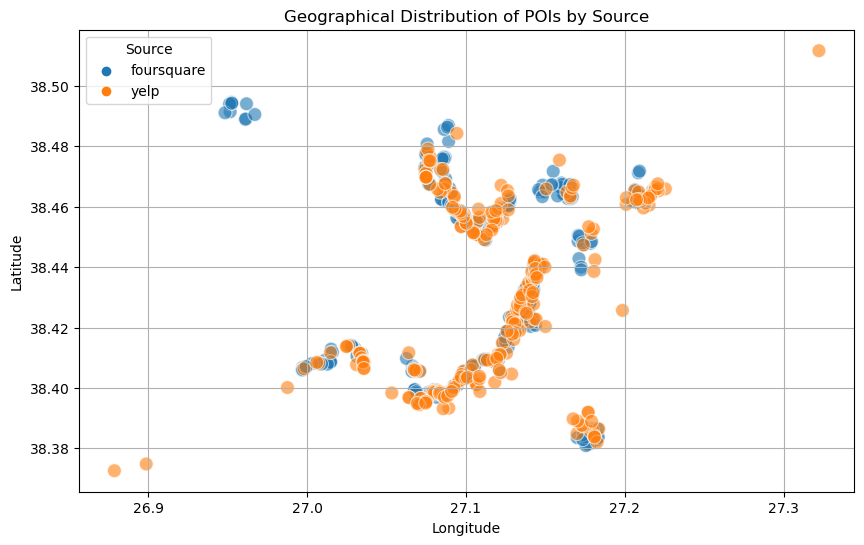

In [22]:
# Geographical Distribution of POIs
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pois_df, x='restaurant_longitude', y='restaurant_latitude', hue='source', alpha=0.6, s=100)
plt.title('Geographical Distribution of POIs by Source')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Source')
plt.grid(True)
plt.show()

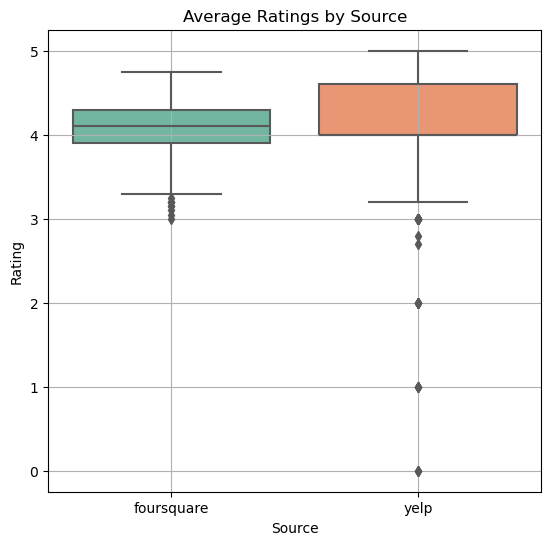

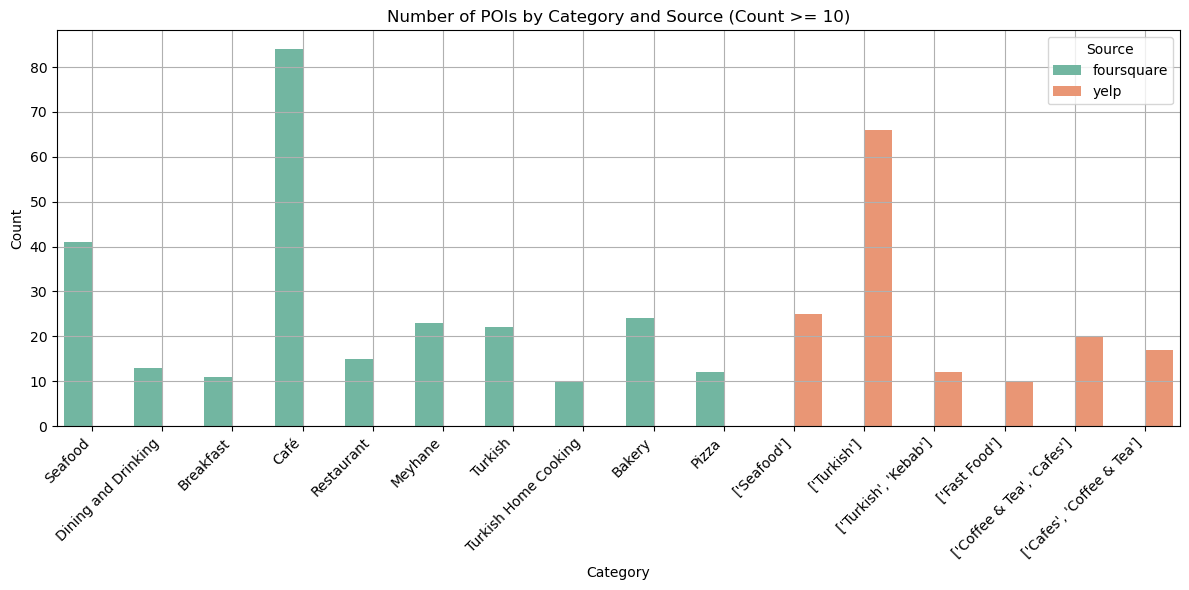

In [23]:
# Comparison of Key Attributes (Ratings and Price Levels)
plt.figure(figsize=(14, 6))

# Average Ratings
plt.subplot(1, 2, 1)
sns.boxplot(data=pois_df, x='source', y='rating', palette='Set2')
plt.title('Average Ratings by Source')
plt.xlabel('Source')
plt.ylabel('Rating')
plt.grid(True)

# Filter categories with count of 10 or higher
category_counts = pois_df['category'].value_counts()
valid_categories = category_counts[category_counts >= 10].index
filtered_pois_df = pois_df[pois_df['category'].isin(valid_categories)]

# Number of POIs by Category (count >= 10)
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_pois_df, x='category', hue='source', dodge=True, palette='Set2')
plt.title('Number of POIs by Category and Source (Count >= 10)')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Source')
plt.grid(True)
plt.tight_layout()
plt.show()

### Section 7: Completeness Analysis

<Figure size 1000x600 with 0 Axes>

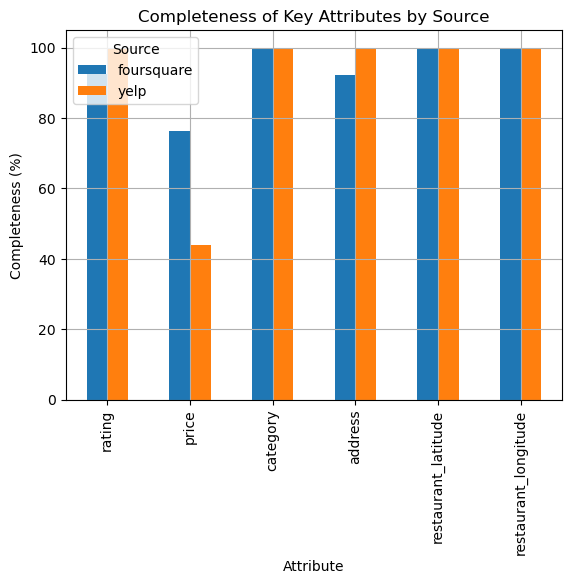

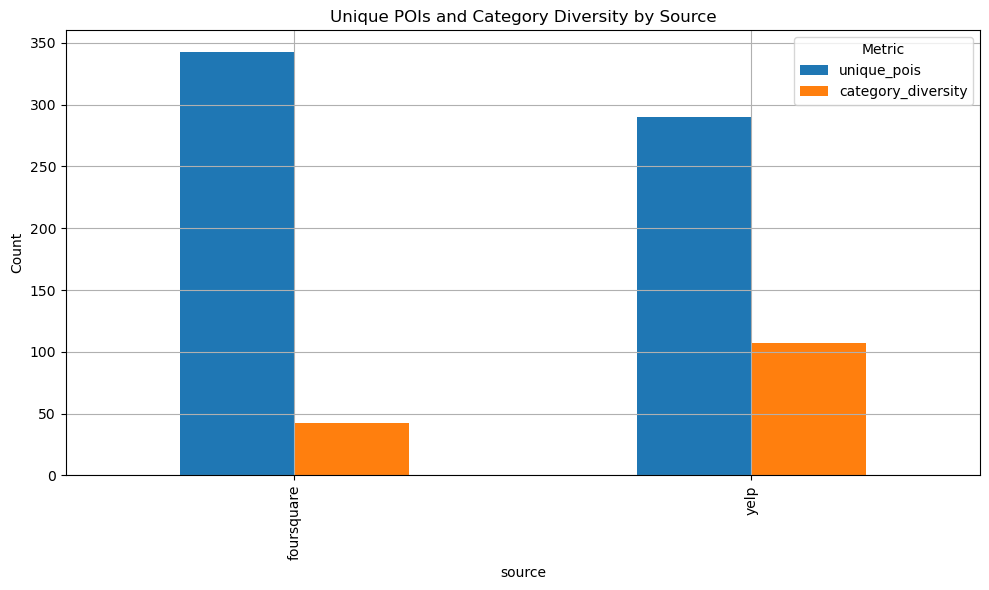

In [16]:
# Comparing Completeness of Yelp vs Foursquare
key_attributes = ['rating', 'price', 'category', 'address', 'restaurant_latitude', 'restaurant_longitude']
completeness = pois_df.groupby('source')[key_attributes].apply(lambda x: x.notnull().mean() * 100)

# Overall Completeness Score
overall_completeness = completeness.mean(axis=1)

# Unique POIs and Category Diversity
unique_pois = pois_df.groupby('source').size()
category_diversity = pois_df.groupby('source')['category'].nunique()

# Visualization of Completeness Metrics
plt.figure(figsize=(10, 6))
completeness.T.plot(kind='bar')
plt.title("Completeness of Key Attributes by Source")
plt.xlabel("Attribute")
plt.ylabel("Completeness (%)")
plt.legend(title='Source')
plt.grid(True)
plt.show()

# Visualization of Unique POIs and Category Diversity
coverage_df = pd.DataFrame({'unique_pois': unique_pois, 'category_diversity': category_diversity})

plt.figure(figsize=(10, 6))
coverage_df.plot(kind='bar', ax=plt.gca())
plt.title("Unique POIs and Category Diversity by Source")
plt.ylabel("Count")
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Conclusion and Discussion of Results
if unique_pois['foursquare'] > unique_pois['yelp']:
    print("\nFoursquare provided more unique POIs than Yelp.")
else:
    print("\nYelp provided more unique POIs than Foursquare.")

if category_diversity['foursquare'] > category_diversity['yelp']:
    print("Foursquare provided greater diversity of categories than Yelp.")
else:
    print("Yelp provided greater diversity of categories than Foursquare.")

more_complete = 'foursquare' if overall_completeness['foursquare'] > overall_completeness['yelp'] else 'yelp'
print(f"\n{more_complete.capitalize()} provided more complete data based on overall completeness of key attributes.")


Foursquare provided more unique POIs than Yelp.
Yelp provided greater diversity of categories than Foursquare.

Foursquare provided more complete data based on overall completeness of key attributes.


### Section 8: Analysis of Top 10 Restaurants by Rating

In [18]:
# Get the top 10 restaurants according to their rating
pois_with_ratings_df = pois_df[pois_df['rating'].notnull()]

# Sort by rating in descending order
sorted_pois_df = pois_with_ratings_df.sort_values(by='rating', ascending=False)

# Get the top 10 restaurants
top_10_restaurants = sorted_pois_df.head(10)

# Display the top 10 restaurants
top_10_restaurants = top_10_restaurants[['restaurant_name', 'rating', 'price', 'category', 'address', 'source']]
print("Top 10 Restaurants by Rating:")
print(top_10_restaurants)

Top 10 Restaurants by Rating:
                       restaurant_name  rating price  \
595                 Öz Urfa Cemal Usta     5.0   NaN   
906                  Bosstanlı Meyhane     5.0   NaN   
899                Aşcı Balık Restoran     5.0   NaN   
894                     Black Jack BBQ     5.0   NaN   
879                       Fuat'in Yeri     5.0   NaN   
865  Öz Servet Pide ve Lahmacun Salonu     5.0   NaN   
856                  Aksoy Pide Salonu     5.0   NaN   
849                 Bolu Mangal Bostan     5.0   NaN   
846                  Ezo Ana Mantı Evi     5.0   NaN   
835              Öz Efe Manisalı Kebap     5.0     ₺   

                                         category  \
595                                   ['Turkish']   
906                                  ['Tabernas']   
899                                   ['Seafood']   
894  ['Barbeque', 'Steakhouses', 'Cocktail Bars']   
879                ['Tapas/Small Plates', 'Pubs']   
865                         ['Lahma